In [66]:
print("Author: Vladimir Eremin\nDescription: Kaggle playground competition")

Author: Vladimir Eremin
Description: Kaggle playground competition


In [67]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
#from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
import warnings
import xgboost as xgb
from collections import defaultdict
import time
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from XGBoost.XGBoostOptimizer import XGBoostOptimizer
from DataProcessing import DataStats


dtypes = {'datetime': 'O',
             'season': 'category',
             'holiday': 'category',
             'workingday': 'category',
             'weather': 'category',
             'temp': 'float64',
             'atemp': 'float64',
             'humidity': 'int64',
             'windspeed': 'float64',
             'casual': 'int64',
             'registered': 'int64',
             'count': 'int64'}

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [68]:
traindf = pd.read_csv('/home/vlad/csv/Social/Bike-sharing-demand/train.csv'
                      ,dtype=dtypes,parse_dates=['datetime'])
print('Df size: ',traindf.shape,'\nMem used: ',round(sum(traindf.memory_usage()/1024/1024),2),'Mb')

Df size:  (10886, 12) 
Mem used:  0.71 Mb


In [69]:
traindf.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [70]:
DataStats.get_df_stats(traindf)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,dtype
0,datetime,10886,0.0,0.009186,datetime64[ns]
1,season,4,0.0,25.114826,category
2,holiday,2,0.0,97.143120,category
3,workingday,2,0.0,68.087452,category
4,weather,4,0.0,66.066507,category
5,temp,49,0.0,4.289914,float64
6,atemp,60,0.0,6.163880,float64
7,humidity,89,0.0,3.380489,int64
8,windspeed,28,0.0,12.061363,float64
9,casual,309,0.0,9.057505,int64


In [71]:
traindf.describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [72]:
#Define a null model - mean count value
null_pred = traindf.describe().loc['mean','count']
print('MAE for Null model: ',round(np.mean(np.abs(traindf['count'] - null_pred)),2))


#traindf['season',	'holiday',	'workingday'	'weather'	'temp'	'atemp'	'humidity'	'windspeed']

MAE for Null model:  142.71


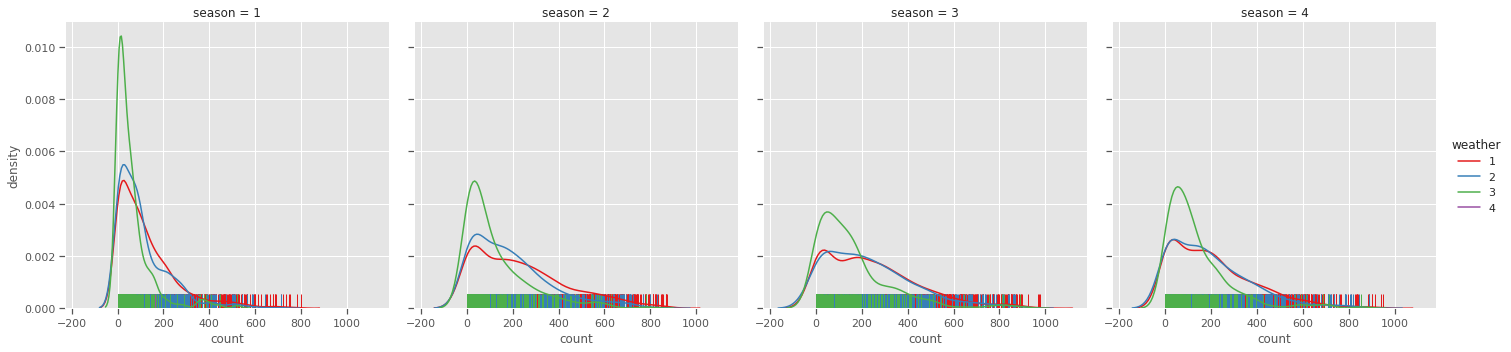

In [73]:
#Seasonality  exploring
g = sns.FacetGrid(traindf, col='season', hue="weather", palette="Set1",size=5)
g = (g.map(sns.distplot, "count", hist=False, rug=True)
    .add_legend()
    .set_ylabels('density'))

Text(0.5,0.98,'Average Count by Season and Waether')

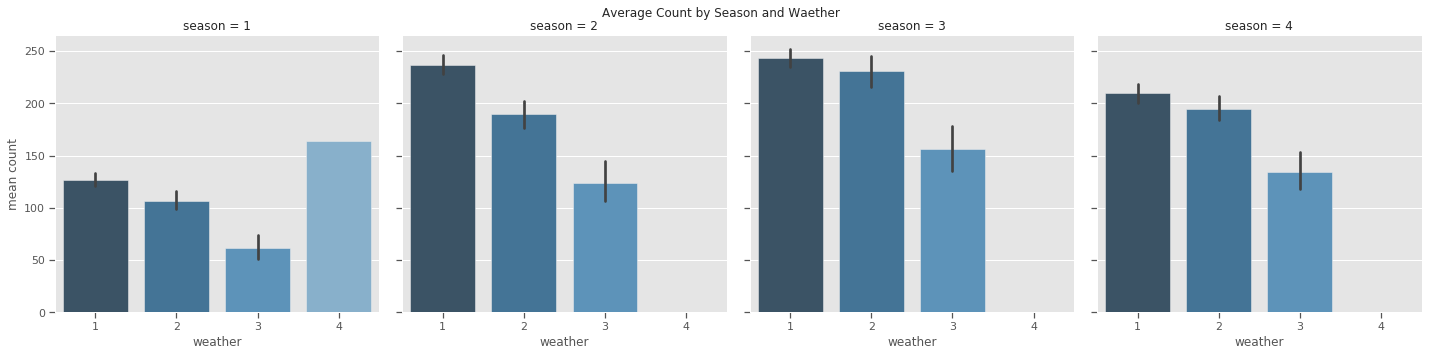

In [111]:
#Seasonality  exploring
g = sns.FacetGrid(traindf, col='season'#, hue="weather"
                  , palette="Set1",size=5)
g = (g.map(sns.barplot,"weather", "count",palette="Blues_d")
    .add_legend()
    .set_ylabels('mean count')
    )
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Average Count by Season and Waether') # can also get the figure from plt.gcf()

Text(0.5,1,'Total Count by Season')

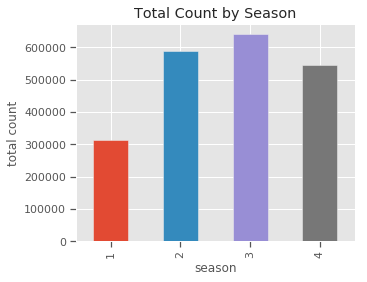

In [100]:
#Tota count by season
plt.figure(figsize=(5,))
traindf.groupby('season')['count'].sum().plot.bar(ax=plt.gca())
plt.ylabel('total count')
plt.title('Total Count by Season')
#.loc[(traindf.weather=='4') &(traindf.season=='1')]['count'].mean()

Text(0.5,0.98,'Average Count by Workingday and Holiday')

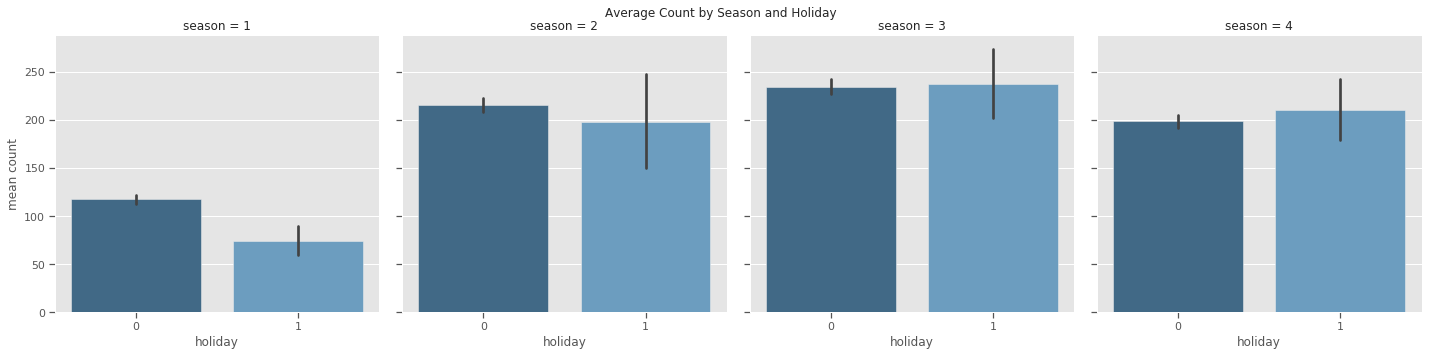

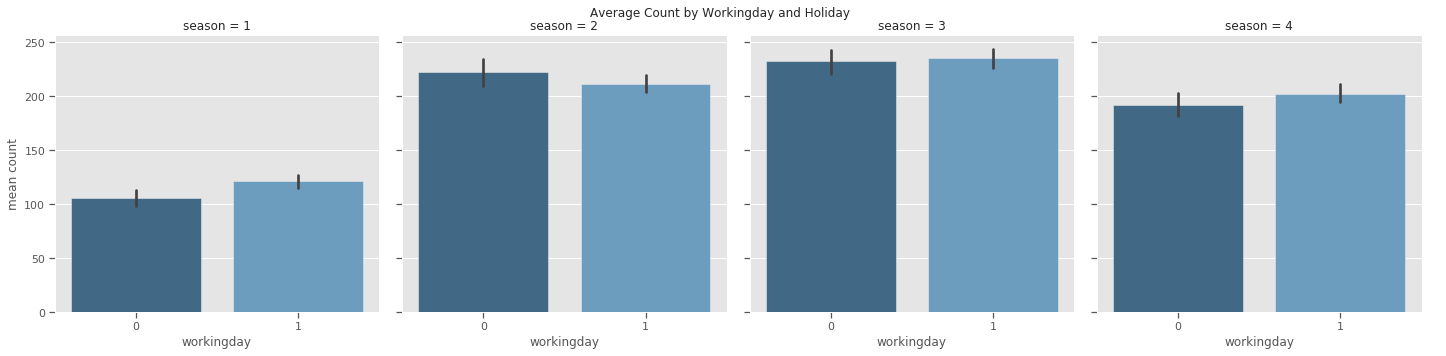

In [112]:
#Holiday  exploring
g = sns.FacetGrid(traindf, col='season'#, hue="weather"
                  , palette="Set1",size=5)
g = (g.map(sns.barplot,"holiday", "count",palette="Blues_d")
    .add_legend()
    .set_ylabels('mean count')
    )

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Average Count by Season and Holiday')

print('\n\n\n')
#Holiday  exploring
g = sns.FacetGrid(traindf, col='season'#, hue="weather"
                  , palette="Set1",size=5)
g = (g.map(sns.barplot,"workingday", "count",palette="Blues_d")
    .add_legend()
    .set_ylabels('mean count')
    )
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Average Count by Workingday and Holiday') 


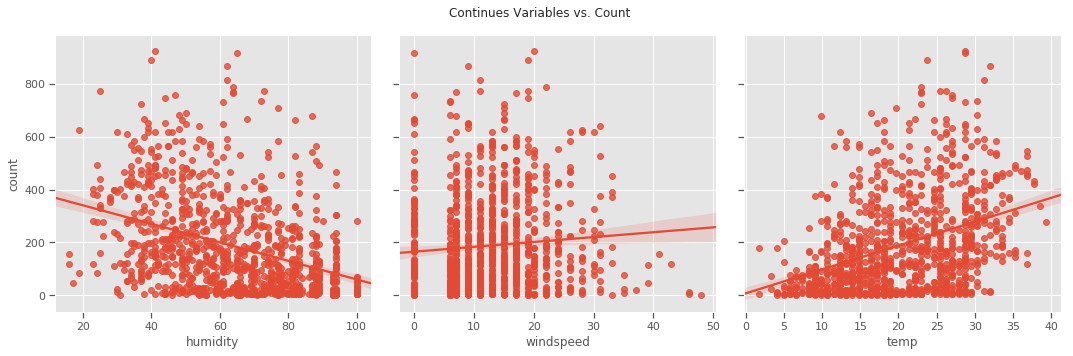

In [196]:
traindf_numerical = traindf[['humidity','windspeed','temp','count']]
g = sns.pairplot(traindf_numerical.sample(1000)
                 ,y_vars=['count'], x_vars=['humidity','windspeed','temp']
                 ,kind="reg"
                ,size=5
                ,palette="Blues_d")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Continues Variables vs. Count');

In [199]:
corr = traindf_numerical.corr(); corr

,humidity,windspeed,temp,count
humidity,1.000000,-0.318607,-0.064949,-0.317371
windspeed,-0.318607,1.000000,-0.017852,0.101369
temp,-0.064949,-0.017852,1.000000,0.394454
count,-0.317371,0.101369,0.394454,1.000000


Text(0.5,1,'Corelation Matrix')

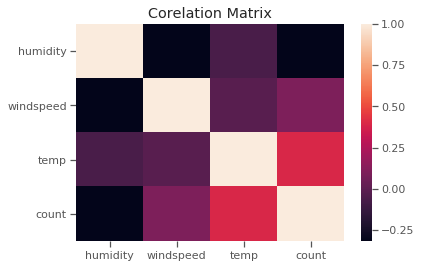

In [198]:

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

#plt.subplots_adjust(top=0.9)
plt.title('Corelation Matrix')

In [181]:
#Feature Engineering

#create a feature "TimeCat" -{0-3}
import time
from time import mktime
import datetime as dt

def getTimeCat(Datetime):
    # extract time categories
    #str_time = datetime.strptime(Datetime, "%m/%j/%y %H:%M").time()
    str_time = Datetime.time()

    # --> Morning = 0400-1000
    mornStart = dt.time(4, 0, 1)
    mornEnd = dt.time(10, 0, 0)

    # --> Midday = 1000-1600
    midStart = dt.time(10, 0, 1)
    midEnd = dt.time(16, 0, 0)

    # --> Evening = 1600-2200
    eveStart = dt.time(16, 0, 1)
    eveEnd = dt.time(22, 0, 0)

    # --> Late Night = 2200-0400
    lateStart = dt.time(22, 0, 1)
    Midnighy = dt.time(0, 0, 0)
    lateEnd = dt.time(4, 0, 0)

    if str_time >= mornStart and str_time <= mornEnd:
      timecat = 0 #morning
    
    elif str_time >= midStart and str_time <= midEnd:
      timecat = 1 #midday
    elif str_time >= eveStart and str_time <= eveEnd:
      timecat = 2 #evening
    elif str_time >= eveStart or (str_time >= Midnighy and str_time <= lateEnd):
      timecat = 3 #late night

    else:
        timecat = -1
    return timecat

#traindf['day_part'] = 


In [185]:
traindf['timecat_'] = traindf.datetime.map(getTimeCat)

Text(0.5,1,'Count by Time Category')

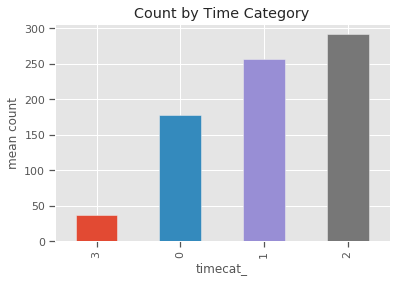

In [191]:
traindf.groupby('timecat_')['count'].mean().sort_values().plot.bar()
plt.ylabel('mean count')
plt.title('Count by Time Category')

In [200]:
traindf['humidity_temp_'] = traindf.humidity * traindf.temp * -1

